In [ ]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import os
from tqdm import tqdm

from scipy.stats import kurtosis, skew

from typing import List, Tuple

from mne.io import read_raw_eeglab
import seaborn as sns


import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc

import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [23]:
# Chunk data into 1 second epochs with 20% overlap
def chunk_data(
    raw: mne.io.Raw, epoch_length=1, overlap=0.2, pick: List[str] = None
) -> List[mne.io.Raw]:
    total_recording_time = raw.times[-1]  # in seconds
    overlap_length = epoch_length * overlap
    start = 0
    epochs = []
    while start + epoch_length < total_recording_time:
        if pick is not None:
            epochs.append(
                raw.copy().pick(pick).crop(tmin=start, tmax=start + epoch_length)
            )
        else:
            epochs.append(raw.copy().crop(tmin=start, tmax=start + epoch_length))
        start += epoch_length - overlap_length
    return epochs


# calculate the mean of each channel over time
def calculate_mean(epochs: List[mne.io.Raw]) -> np.ndarray:
    means = []
    for epoch in epochs:
        try:
            means.append(epoch.get_data().mean(axis=1))
        except:
            print("Error")
            print(epoch.get_data().shape)
            break

    return np.array(means)


# calculate the Variance and Standard Deviation of each channel over time
def calculate_variance(epochs: List[mne.io.Raw]) -> np.ndarray:
    variances = []
    for epoch in epochs:
        variances.append(epoch.get_data().var(axis=1))
    return np.array(variances)


def calculate_std(epochs: List[mne.io.Raw]) -> np.ndarray:
    stds = []
    for epoch in epochs:
        stds.append(epoch.get_data().std(axis=1))
    return np.array(stds)


# calculate the Peak-to-Peak Amplitude of each channel over time
def calculate_peak_to_peak(epochs: List[mne.io.Raw]) -> np.ndarray:
    peak_to_peaks = []
    for epoch in epochs:
        peak_to_peaks.append(epoch.get_data().ptp(axis=1))
    return np.array(peak_to_peaks)


# calculate the Root Mean Square (RMS) of each channel over time
def calculate_rms(epochs: List[mne.io.Raw]) -> np.ndarray:
    rms = []
    for epoch in epochs:
        rms.append(np.sqrt(np.mean(epoch.get_data() ** 2, axis=1)))
    return np.array(rms)


# calculate the Skewness and Kurtosis of each channel over time
def calculate_skewness(epochs: List[mne.io.Raw]) -> np.ndarray:
    skewness_value = []
    for epoch in epochs:
        skewness_value.append(skew(epoch.get_data(), axis=1))
    return np.array(skewness_value)


def calculate_kurtosis(epochs: List[mne.io.Raw]) -> np.ndarray:
    kurtosis_value = []
    for epoch in epochs:
        kurtosis_value.append(kurtosis(epoch.get_data(), axis=1))
    return np.array(kurtosis_value)


def calculate_features(
    epochs: List[mne.io.Raw], is_channel_wise: bool = True
) -> pd.DataFrame:
    mean = calculate_mean(epochs)
    variance = calculate_variance(epochs)
    std = calculate_std(epochs)
    peak_to_peak = calculate_peak_to_peak(epochs)
    rms = calculate_rms(epochs)
    skewness = calculate_skewness(epochs)
    kurtosis = calculate_kurtosis(epochs)

    if is_channel_wise:
        axis = 0
    else:
        axis = 1

    return pd.DataFrame(
        {
            "mean": mean.mean(axis=axis),
            "variance": variance.mean(axis=axis),
            "std": std.mean(axis=axis),
            "peak_to_peak": peak_to_peak.mean(axis=axis),
            "rms": rms.mean(axis=axis),
            "skewness": skewness.mean(axis=axis),
            "kurtosis": kurtosis.mean(axis=axis),
        }
    )

In [25]:
input_fnames = {
    "pre": [
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.set",
    ],
    "break": [
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_RELAX.set",
    ],
    "post": [
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.set",
        # "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.set",
    ],
}

epoch_length = 5
overlap = 0
eog = ()

with open("../output_data/channel_names.txt", "r") as f:
    channel_names = f.read().splitlines()


channel_wise_results = {}

for channel in tqdm(
    channel_names, total=len(channel_names), desc="Channels", position=0
):
    if isinstance(channel, str):
        channel = [channel.strip()]

    pre_epochs = []
    for input_fname in input_fnames["pre"]:
        pre_raws = read_raw_eeglab(
            input_fname=input_fname,
            eog=eog,
            preload=True,
            montage_units="mm",
            verbose=True,
        )
        pre_epochs.extend(
            chunk_data(
                pre_raws, epoch_length=epoch_length, overlap=overlap, pick=channel
            )
        )

    post_epochs = []
    for input_fname in input_fnames["post"]:
        post_raws = read_raw_eeglab(
            input_fname=input_fname,
            eog=eog,
            preload=True,
            montage_units="mm",
            verbose=True,
        )
        post_epochs.extend(
            chunk_data(
                post_raws, epoch_length=epoch_length, overlap=overlap, pick=channel
            )
        )

    pre_features = calculate_features(
        pre_epochs, is_channel_wise=False
    )  # 1 row per epoch
    post_features = calculate_features(
        post_epochs, is_channel_wise=False
    )  # 1 row per epoch
    pre_features["label"] = 0  # "pre"
    post_features["label"] = 1  # "post"

    features = pd.concat([pre_features, post_features])

    # Define the models and parameters for grid search
    models_and_parameters = {
        "SVM": (
            SVC(),
            {"svm__C": [1e-3, 1e-2, 0.1, 1, 10, 1e3], "svm__kernel": ["linear", "rbf"]},
        ),
        "Decision_Tree": (
            DecisionTreeClassifier(),
            {
                "decision_tree__max_depth": [3, 5, 10],
                "decision_tree__min_samples_split": [2, 5, 10],
            },
        ),
        "LDA": (LinearDiscriminantAnalysis(), {"lda__solver": ["svd", "lsqr"]}),
        "MLP": (
            MLPClassifier(max_iter=1000),
            {
                "mlp__hidden_layer_sizes": [
                    (50,),
                    (100,),
                    (
                        100,
                        10,
                    ),
                ],
                "mlp__activation": ["tanh", "relu"],
                "mlp__alpha": [0.0001, 0.001, 0.01],
            },
        ),
        "RandomForestClassifier": (
            RandomForestClassifier(),
            {
                "randomforestclassifier__n_estimators": [40, 50, 60],
                "randomforestclassifier__max_features": ["sqrt", "log2"],
            },
        ),
        "XGBClassifier": (
            XGBClassifier(),
            {
                "xgbclassifier__n_estimators": [50, 100, 200],
                "xgbclassifier__learning_rate": [0.01, 0.1, 0.2],
                "xgbclassifier__subsample": [0.7, 0.8, 0.9],
            },
        ),
    }

    # Define 5-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # List to hold the best models for each classifier
    best_models = []

    results = {
        "experiment_name": [],
        "model_name": [],
        "best_params": [],
        "best_score": [],
        "test_score": [],
        "grid_search_std_test_score": [],
        "grid_search_mean_test_score": [],
    }

    for experiment_name in [
        "all_features",
        "mean",
        "variance",
        "std",
        "peak_to_peak",
        "rms",
        "skewness",
        "kurtosis",
    ]:
        # Create a synthetic dataset

        if experiment_name == "all_features":
            X, y = (
                features.drop("label", axis=1).to_numpy(),
                features["label"].to_numpy(),
            )
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )

        else:
            X, y = (
                features[experiment_name].to_numpy().reshape(-1, 1),
                features["label"].to_numpy(),
            )
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )

        # Loop through models and parameters, and perform grid search
        for name, (model, params) in tqdm(models_and_parameters.items()):

            pipeline = Pipeline(
                [
                    ("scaler", StandardScaler()),  # Data standardization
                    (name.lower(), model),  # Model
                ]
            )
            clf = GridSearchCV(
                pipeline, params, cv=kfold, scoring="accuracy", n_jobs=-1
            )
            clf.fit(X_train, y_train)
            print(f"Best parameters for {name}: {clf.best_params_}")
            print(f"Best cross-validation score for {name}: {clf.best_score_:.3f}")
            best_models.append(clf.best_estimator_)

            results["model_name"].append(name)
            results["best_params"].append(clf.best_params_)
            results["best_score"].append(clf.best_score_)
            results["test_score"].append(clf.best_estimator_.score(X_test, y_test))
            results["experiment_name"].append(experiment_name)
            results["grid_search_std_test_score"].append(
                np.mean(clf.cv_results_["std_test_score"])
            )
            results["grid_search_mean_test_score"].append(
                np.mean(clf.cv_results_["mean_test_score"])
            )

    channel_wise_results[channel[0]] = pd.DataFrame(results)

Channels:   0%|          | 0/58 [00:00<?, ?it/s]

Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.612
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.513
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.621


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.586


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.568


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.594


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.540
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.550
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.405


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.504


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.496


100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.524


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.622
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.604
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.622


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.622


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.514


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.585


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.613
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.604
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.613


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.622


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.514


100%|██████████| 6/6 [00:01<00:00,  3.39it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.585


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.613
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.522
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.613


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.622


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.477


100%|██████████| 6/6 [00:01<00:00,  3.21it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.513


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.613
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.604


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.613
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.622


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.514


100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.586


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.550
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.640
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.432


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.587


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.595


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.566


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.513
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.604
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.451


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.576


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.568


Channels:   2%|▏         | 1/58 [00:24<22:51, 24.06s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.550
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.604
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.594
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.594


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.559


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.594


100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.567


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.468
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.468


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.513


100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.540


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.640


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.612
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.641
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.641


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.449


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.567


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.631


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.612
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.632
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.641


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.458


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.567


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.621


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.568
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.568


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.630


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.540


100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.576


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.631


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.603
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.632
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.632


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.449


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.558


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.567


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.595
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.559
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.586


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.604


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.523


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.531
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.542
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.560


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.486


Channels:   3%|▎         | 2/58 [00:51<24:14, 25.98s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.531
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.630
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.649
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.576


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.658


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.631


100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.649


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.459
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.487
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.458


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.494


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.505


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.559


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.595


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.567
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.586
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.631


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.557


100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.566


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.595


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.567
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.631


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.631


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.557


100%|██████████| 6/6 [00:02<00:00,  2.76it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.566


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.532
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.558
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.441


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.468


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.595
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.567


Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.631


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.623


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.548


100%|██████████| 6/6 [00:02<00:00,  2.41it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.566


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.595


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.623
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.531
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.649


100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.596


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.487


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.560
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.504
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.549


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.550


Channels:   5%|▌         | 3/58 [01:18<24:28, 26.71s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.560
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.495
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.558
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.540


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.531


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.531


100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.594


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.603
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.612
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.568


100%|██████████| 6/6 [00:03<00:00,  1.58it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.567


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.468


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.568
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.541


100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.477


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.522


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.558
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.550


100%|██████████| 6/6 [00:02<00:00,  2.78it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.477


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.477


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.551
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.468


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.587


100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.613


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.522


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.523
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.558
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.559


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.504


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.568


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.550
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.477
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.550


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.532


100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.532


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.512
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.487


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.460
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.531


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.405


Channels:   7%|▋         | 4/58 [01:50<25:45, 28.63s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.487
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.622
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.576
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.604


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.596


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.576


100%|██████████| 6/6 [00:12<00:00,  2.01s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.477


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.504
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.414
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.487


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.585


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.559


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.550


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.568
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.559


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.596


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.423


100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.513


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.540


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.568
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.559
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.587


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.423


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.513


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.559
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.631
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.550


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.595


100%|██████████| 6/6 [00:02<00:00,  2.56it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.613


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.540
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.568
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.559
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.604


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.432


100%|██████████| 6/6 [00:02<00:00,  2.47it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.513


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.585


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.596
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.458
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.559


100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.523


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.622


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.640
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.531
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.622


Channels:   9%|▊         | 5/58 [02:21<26:04, 29.52s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.666
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.576
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.504
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.558


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.523


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.494


100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.505


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.585
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.477


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.432
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.451


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.495


100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.541


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.594


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.513
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.558
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.603


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.486


100%|██████████| 6/6 [00:02<00:00,  2.76it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.576


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.576
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.513
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.567
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.621


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.477


100%|██████████| 6/6 [00:02<00:00,  2.70it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.576


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.602


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.585
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.557
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.611


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.539


100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.576


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.540
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.567
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.504


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.585


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.432
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.515
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.449


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.468


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.458


100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.532


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.487


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.496
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.414
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.532


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.433


Channels:  10%|█         | 6/58 [02:53<26:22, 30.43s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.442
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.548
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.505
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.566


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.549


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.530


100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.513


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.522


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.649
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.359
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.495


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.622


100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.595


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.567


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.566
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.549
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.548


100%|██████████| 6/6 [00:01<00:00,  3.21it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.603


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.576
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.566
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.558
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.548


100%|██████████| 6/6 [00:01<00:00,  3.21it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.603


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.504


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.513
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.531
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.549


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.513


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.522


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.576
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.566
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.558


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.566


100%|██████████| 6/6 [00:01<00:00,  3.39it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.603


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.541
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.505
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.414


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.505


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.541


100%|██████████| 6/6 [00:02<00:00,  2.18it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.486


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.468


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.522
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.368
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.457


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.594


Channels:  12%|█▏        | 7/58 [03:20<24:52, 29.26s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.504
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.576
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.532
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.512


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.513


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.476


100%|██████████| 6/6 [00:09<00:00,  1.50s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.504


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.585


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.558
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.460


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.505


100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.513


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.567
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.540
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.505


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.569


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.513
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.567
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.568


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.514


100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.569


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.423
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.459
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.487


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.532


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.458


100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.477


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.522


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.585


 33%|███▎      | 2/6 [00:00<00:00,  5.66it/s]

Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.568


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.587


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.549


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.523
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.549
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.585


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.505


100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.514


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.594


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.594
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.486
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.621


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.504


Channels:  14%|█▍        | 8/58 [03:45<23:18, 27.96s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.496
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.622
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.549
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.603


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.613


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.530


100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.558


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.423
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.459
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.442


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.423


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.452


100%|██████████| 6/6 [00:04<00:00,  1.43it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.505


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.495
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.450


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.568
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.377


100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.460


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.522
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.450


Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.577
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.595


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.377


100%|██████████| 6/6 [00:01<00:00,  3.23it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.460


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.459


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.513
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.387
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.450


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.495


100%|██████████| 6/6 [00:01<00:00,  3.30it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.558


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.522


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.459
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.577
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.586


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.396


100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.460


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.558
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.548


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.585


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.604


100%|██████████| 6/6 [00:02<00:00,  2.80it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.523


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.586


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.559
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.558
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.541


Channels:  16%|█▌        | 9/58 [04:15<23:20, 28.59s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.631
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.612
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.586
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.630


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.522


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.486


100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.576


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.495
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.460


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.594


100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.477
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.477
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.505


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.540


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.451


100%|██████████| 6/6 [00:01<00:00,  3.91it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.425


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.459


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.477
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.496
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.540


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.460


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.425


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.504
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.585
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.468


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.504


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.522


100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.621


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.459
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.477
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.496


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.531


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.441


100%|██████████| 6/6 [00:01<00:00,  4.35it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.442


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.557


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.576
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.576
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.585


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.522


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.531


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.621


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.612
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.567
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.630


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.585


Channels:  17%|█▋        | 10/58 [04:42<22:17, 27.87s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.550
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.631
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.593
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.666


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.604


100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.603


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.423


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.424


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.477


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.604


100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.585


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.513


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.559
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.468
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.550


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.605


100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.505


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.523


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.559
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.496
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.550


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.605


100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.505


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.558
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.567
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.521


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.575


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.621


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.523
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.587
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.496


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.532


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.596


100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.523


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.577


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.542
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.485
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.576


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.460


100%|██████████| 6/6 [00:02<00:00,  2.59it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.487


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.585


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.549
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.586
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.595


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.568


Channels:  19%|█▉        | 11/58 [05:07<21:09, 27.01s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.585
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.630
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.559
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.604


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.569


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.632


100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.613


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.470
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.495


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.504


100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.551


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.495
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.540
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.450


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.504


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.495
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.540
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.459


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.495


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.532


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.460


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.594
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.486


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.612


100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.495
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.567
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.459


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.487


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.559


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.586


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.550
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.532


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.496


100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.540


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.585


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.587
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.558
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.478


Channels:  21%|██        | 12/58 [05:36<21:10, 27.62s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.560
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.640
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.631
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.567


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.650


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.613


100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.668


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.512


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.568
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.415
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.487


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.522


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.495
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.432
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.441


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.496


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.415


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.433


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.495


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.432
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.505


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.423


100%|██████████| 6/6 [00:01<00:00,  3.38it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.433


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.568


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.532
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.550


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.569


100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.495
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.441
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.477


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.460


100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.433


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.568


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.650
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.396


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.550


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.683


100%|██████████| 6/6 [00:02<00:00,  2.18it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.649


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.604
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.658
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.594


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.595


Channels:  22%|██▏       | 13/58 [06:03<20:40, 27.56s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.577
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.640
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.604
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.567


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.658


100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.675


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.423
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.460


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.469


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.404


100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.432


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.523


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.558
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.513
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.532


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.460


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.567


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.550
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.558
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.513


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.541


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.469


100%|██████████| 6/6 [00:02<00:00,  2.84it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.567


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.549
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.495
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.377


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.558


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.460


100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.523


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.550


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.568
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.513
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.541


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.469


100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.558


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.532


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.514


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.486


100%|██████████| 6/6 [00:02<00:00,  2.78it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.541
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.560


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.531
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.567


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.560


Channels:  24%|██▍       | 14/58 [06:34<20:53, 28.49s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.568
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.585
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.513
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.549


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.613


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.540


100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.497
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.531
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.495


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.495


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.513


100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.602


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.549
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.396


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.558


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.441


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.450


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.549


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.432
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.441


100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.450


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.629


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.558
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.341
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.647


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.603


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.549


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.432
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.558


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.413


100%|██████████| 6/6 [00:01<00:00,  3.23it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.432


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.488
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.487
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.496


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.469


100%|██████████| 6/6 [00:03<00:00,  1.80it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.531


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.549
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.477
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.541


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.369


Channels:  26%|██▌       | 15/58 [07:01<20:08, 28.11s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.533
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.675
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.621
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.667


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.613


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.630


100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.621


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.468
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.469
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.477


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.487


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.478


100%|██████████| 6/6 [00:01<00:00,  4.01it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.469


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.630
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.631
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.477


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.640


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.532


100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.639


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.631
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.495
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.640


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.532


100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.667
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.631
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.512


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.675


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.541


100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.657


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.639


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.613
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.495
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.640


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.541


100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.577


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.532
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.424
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.587


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.460


100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.595


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.577


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.604
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.559
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.551


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.577


Channels:  28%|██▊       | 16/58 [07:29<19:38, 28.06s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.515
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.585
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.558
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.612


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.514


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.532


100%|██████████| 6/6 [00:08<00:00,  1.44s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.504


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.531
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.414
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.469


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.512


100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.558


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.630


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.640
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.584
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.630


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.576


100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.576


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.602


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.640
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.566
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.558


100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.576


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.603


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.621
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.603
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.621


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.641


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.602
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.603
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.566


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.639


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.576


100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.567


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.612
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.521


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.458
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.549


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.486


100%|██████████| 6/6 [00:02<00:00,  2.75it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.513


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.513


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.569
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.396
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.505


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.495


Channels:  29%|██▉       | 17/58 [07:54<18:32, 27.12s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.541
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.639
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.594
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.630


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.584


100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.566


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.586
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.604


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.479


100%|██████████| 6/6 [00:02<00:00,  2.45it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.514


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.549
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.585


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.495
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.585


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.585


100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.620


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.611


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.585
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.504
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.594


100%|██████████| 6/6 [00:02<00:00,  2.85it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.620


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.584
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.568


Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.467
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.522


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.593


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.567


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.611


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.585
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.504
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.585


100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.620


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.612
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.602


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.514


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.540
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.477
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.549


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.585


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.503


Channels:  31%|███       | 18/58 [08:20<17:51, 26.79s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.558
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.676
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.594
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.629


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.666


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.638


100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.640


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.521
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.522
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.433


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.513


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.503


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.504


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.522
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.504
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.467


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.504


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.494


100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.567


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.504
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.504


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.486
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.513


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.494


100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.567


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.467
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.477
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.387


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.440


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.432


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.477


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.504


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.540
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.486
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.532


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.485


100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.576


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.612


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.594
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.621
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.621


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.541


100%|██████████| 6/6 [00:01<00:00,  3.33it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.577
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.532
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.568


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.613


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.522


Channels:  33%|███▎      | 19/58 [08:45<17:05, 26.29s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.586
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.640
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.569
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.622


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.667


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.693


100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.720


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.558
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.595
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.442


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.505


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.540


100%|██████████| 6/6 [00:02<00:00,  2.61it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.603


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.431


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.559
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.450
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.468


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.613


100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.422


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.559
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.432


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.468


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.604


100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.514


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.523
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.549


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.558


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.478


100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.460


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.422


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.595
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.450


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.621


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.559


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.522
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.513
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.558


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.505


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.704
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.649
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.604
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.677


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.622


Channels:  34%|███▍      | 20/58 [09:11<16:30, 26.06s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.640
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.594
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.587
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.522


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.604


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.568


100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.613


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.504


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.396
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.496


100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.524


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.415
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.442
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.449


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.442


100%|██████████| 6/6 [00:02<00:00,  2.47it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.495


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.423
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.442
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.414


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.451


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.442


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.495


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.585
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.630
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.522


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.576


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.577


100%|██████████| 6/6 [00:01<00:00,  3.54it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.532


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.423
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.442


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.414
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.451


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.432


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.495


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.568
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.585
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.414


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.495


100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.577
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.604
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.568


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.622


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.622


Channels:  36%|███▌      | 21/58 [09:38<16:24, 26.60s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.622
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.577
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.569
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.523


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.623


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.560


100%|██████████| 6/6 [00:08<00:00,  1.45s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.559


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.558


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.505
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.451


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.504


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.432


100%|██████████| 6/6 [00:02<00:00,  2.44it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.523


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.441
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.459


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.432


100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.478


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.441
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.442


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.432


100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.478


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.432
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.423
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.442


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.514


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.460


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.460


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.441
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.496


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.459


100%|██████████| 6/6 [00:03<00:00,  1.88it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.469


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.532
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.532


Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.433
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.496


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.532


100%|██████████| 6/6 [00:02<00:00,  2.68it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.586


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.559
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.542


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.504
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.559


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.559


Channels:  38%|███▊      | 22/58 [10:08<16:31, 27.55s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.531
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.531
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.549
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.431


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.567


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.568


100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.505


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.432
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.486


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.549


100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.533


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.550
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.586
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.369


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.459


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.595


100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.624


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.523
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.586
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.369


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.486


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.604


100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.624


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.505
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.587


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.414


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.487


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.541


100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.523
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.586
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.369


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.496


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.595


100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.624


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.523


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.549
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.513
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.523


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.522


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.585


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.478


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.460
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.513


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.532


Channels:  40%|███▉      | 23/58 [10:37<16:14, 27.84s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.585
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.522
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.506
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.531


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.532


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.459


100%|██████████| 6/6 [00:09<00:00,  1.50s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.458


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.477


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.506
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.414
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.532


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.497


100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.397
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.378


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.458


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.352


100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.415


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.397
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.387
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.441


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.370


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.415


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.423
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.477
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.368


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.467


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.478


100%|██████████| 6/6 [00:01<00:00,  3.21it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.434


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.397
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.387


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.477


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.361


100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.424


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.595
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.540
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.539


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.567


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.477


100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.558


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.568


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.487
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.585
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.585


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.468


Channels:  41%|████▏     | 24/58 [11:02<15:19, 27.03s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.468
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.649
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.639
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.577


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.621


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.593


100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.657


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.468


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.505
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.415
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.477


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.531


100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.612


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.557
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.594
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.603


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.485


100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.522


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.603


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.557
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.603
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.485


100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.522


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.630


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.630
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.585
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.621


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.577


100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.559


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.603
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.584
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.603


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.485


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.530


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.505
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.523
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.450
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.505


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.451


100%|██████████| 6/6 [00:03<00:00,  1.71it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.504


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.468
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.576
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.486


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.449


Channels:  43%|████▎     | 25/58 [11:28<14:43, 26.77s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.549
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.522
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.549


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.530


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.558


100%|██████████| 6/6 [00:08<00:00,  1.46s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.602


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.541
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.585
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.486


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.549


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.514


100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.549
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.522
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.531


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.531


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.566


100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.558


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.549
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.522
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.540


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.540


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.566


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.558


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.585
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.623
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.567


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.576


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.640


100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.576


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.549


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.522
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.540
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.549


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.575


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.523


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.486
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.540
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.549


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.576


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.506


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.432
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.495
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.368


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.441


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.494


Channels:  45%|████▍     | 26/58 [11:54<14:05, 26.42s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.494
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.586
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.603
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.531


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.621


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.612


100%|██████████| 6/6 [00:09<00:00,  1.60s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.585


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.603
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.531


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.451
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.495


100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.541


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.540
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.594
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.531
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.540


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.567


100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.622


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.540
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.594


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.540
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.549


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.576


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.622


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.567
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.621
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.504
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.604


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.567


100%|██████████| 6/6 [00:02<00:00,  2.02it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.640


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.549


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.585
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.540
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.531


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.567


100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.622


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.594
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.585
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.603
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.603


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.559


100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.576


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.523
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.377


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.432


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.431


Channels:  47%|████▋     | 27/58 [12:23<14:10, 27.44s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.477
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.504
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.486
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.504


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.477


100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.558


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.477
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.549
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.515


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.514


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.450


100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.513


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.478
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.387
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.413


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.469


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.540


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.478
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.387


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.414


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.478


100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.540


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.523
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.496
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.378
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.486


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.460


100%|██████████| 6/6 [00:03<00:00,  1.90it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.513


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.478
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.387


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.450


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.478


100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.540


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.585


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.586
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.504
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.549


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.550


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.541


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.505
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.613
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.477


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.514


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.613


Channels:  48%|████▊     | 28/58 [12:56<14:25, 28.86s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.577
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.549
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.504
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.494


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.549


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.494


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.531


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.549


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.541
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.468
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.514


100%|██████████| 6/6 [00:02<00:00,  2.61it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.476
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.477
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.387


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.468


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.451


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.486


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.468
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.477


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.378
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.467


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.460


100%|██████████| 6/6 [00:01<00:00,  3.32it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.486


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.496


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.532
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.496


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.505


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.495


100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.559


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.468
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.477


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.378
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.504


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.451


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.477


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.568


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.602
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.513
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.494


100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.585


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.567


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.558
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.486
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.576


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.549


Channels:  50%|█████     | 29/58 [13:21<13:24, 27.74s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.621
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.623
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.604


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.576


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.595


100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.649


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.532
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.595
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.432


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.550


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.595


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.586


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.532
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.523
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.369


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.514


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.486


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.586


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.532
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.523
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.369


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.505


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.477


100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.586


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.568
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.549
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.441


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.558


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.450


100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.523


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.532
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.523
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.369


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.514


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.486


100%|██████████| 6/6 [00:02<00:00,  2.74it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.586


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.487
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.505


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.559


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.433


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.505


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.432


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.477
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.442
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.514


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.432


Channels:  52%|█████▏    | 30/58 [13:46<12:38, 27.08s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.550
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.541
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.568
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.513


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.558


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.513


100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.541


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.488
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.595
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.414


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.497


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.632


100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.495
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.542
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.351


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.478


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.451


100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.460


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.477
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.542
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.378


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.487


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.459


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.460


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.487


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.513
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.442
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.487


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.505


100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.468


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.551
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.378
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.496


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.469


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.469


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.631
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.560
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.479


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.541


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.596


100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.568


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.532
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.577
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.532


Channels:  53%|█████▎    | 31/58 [14:13<12:07, 26.95s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.532
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.659
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.623
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.596


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.586


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.594


100%|██████████| 6/6 [00:08<00:00,  1.44s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.522
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.613
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.477


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.504


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.577


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.559


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.568
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.432


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.585


100%|██████████| 6/6 [00:01<00:00,  3.43it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.513


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.450
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.396


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.450


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.603


100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.513


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.459
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.451


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.450
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.505


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.432


100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.461


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.450


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.558
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.396
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.423


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.567


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.495


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.604


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.595
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.560
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.632


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.559


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.630


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.668
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.596
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.632


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.685


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.524


Channels:  55%|█████▌    | 32/58 [14:38<11:30, 26.55s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.603
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.594
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.569
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.523


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.665


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.605


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.650


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.449
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.424


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.459


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.547


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.467


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.595
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.488


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.513
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.604


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.407


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.515


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.568


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.488
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.513


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.595


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.416


100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.515


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.532
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.513


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.558


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.568


100%|██████████| 6/6 [00:02<00:00,  2.87it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.568
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.488


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.513
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.613


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.425


100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.533


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.569
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.613
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.541


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.578


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.623


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.585


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.530


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.459
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.442
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.487


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.459


Channels:  57%|█████▋    | 33/58 [15:03<10:51, 26.08s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.530
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.585


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.702
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.540


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.604


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.602


100%|██████████| 6/6 [00:15<00:00,  2.55s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.630


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.469
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.541


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.486


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.477


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.576


100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.523


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.594
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.675
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.594


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.630


100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.650


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.613
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.675


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.576


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.639


100%|██████████| 6/6 [00:02<00:00,  2.41it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.650


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.557
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.512
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.558


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.576


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.451


100%|██████████| 6/6 [00:01<00:00,  3.89it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.532


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.613
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.666
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.576


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.630


100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.659


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.568
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.568


Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.523
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.532


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.586


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.459
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.478
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.441


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.477


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.423


Channels:  59%|█████▊    | 34/58 [15:38<11:30, 28.77s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.530
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.640
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.612
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.649


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.675


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.647


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.666


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.442
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.468
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.477


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.486


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.495


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.541


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.621
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.575
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.585


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.530


100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.504


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.612


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.575
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.576
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.530


100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.504


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.576


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.566
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.575


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.521


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.547


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.612
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.575
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.576


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.603


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.513


100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.522


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.513
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.542
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.505
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.540


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.532


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.514


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.594
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.576
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.369


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.576


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.495


Channels:  60%|██████    | 35/58 [16:04<10:37, 27.73s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.550
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.585
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.487


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.622


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.559


100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.603


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.505
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.623
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.505


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.567


100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.477


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.477
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.487
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.523


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.432


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.504


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.459
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.477
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.477


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.523


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.432


100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.504


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.449
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.576
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.522


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.531


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.459


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.486
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.477
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.460


100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.504


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.550


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.488
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.568
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.487


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.488


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.541
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.651
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.459


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.602


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.649


Channels:  62%|██████▏   | 36/58 [16:31<10:05, 27.53s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.623
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.522
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.451


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.559


100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.533


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.549


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.531
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.522
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.441


100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.531


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.586
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.613
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.396


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.532


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.604


100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.577


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.613
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.414
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.505


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.604


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.514


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.531
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.496


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.433


100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.531


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.577
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.613
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.414


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.532


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.595


100%|██████████| 6/6 [00:02<00:00,  2.47it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.504


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.477
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.478
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.496


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.443


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.542


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.497
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.524
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.440


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.496


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.542


Channels:  64%|██████▍   | 37/58 [17:00<09:47, 27.99s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.487
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.568
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.540
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.541


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.567


100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.613


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.541
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.585
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.432


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.658


100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.585


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.541


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.586
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.468
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.558


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.513


100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.550


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.568


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.586
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.450
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.550


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.521


100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.550


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.505
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.532
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.396
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.541


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.495


100%|██████████| 6/6 [00:03<00:00,  1.74it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.504


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.568
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.586
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.450


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.550


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.531


100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.550


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.515


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.406
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.487


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.425


100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.514


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.595
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.542
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.451


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.550


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.548


Channels:  66%|██████▌   | 38/58 [17:28<09:20, 28.01s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.531
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.558
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.586
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.568


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.541


100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.650
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.650
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.468


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.642


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.470


100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.595


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.567


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.604
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.531
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.558


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.495


100%|██████████| 6/6 [00:02<00:00,  2.46it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.567


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.531


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.604
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.549
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.604


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.504


100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.567


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.559
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.541
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.460


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.551


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.496


100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.533


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.531


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.604
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.549
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.586


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.513


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.567


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.577


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.550
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.560
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.568


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.542


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.451


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.541
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.451
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.541


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.514


Channels:  67%|██████▋   | 39/58 [17:57<08:58, 28.36s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.532
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.542
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.560


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.551


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.531


100%|██████████| 6/6 [00:11<00:00,  1.97s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.632


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.541
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.541
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.559


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.478


100%|██████████| 6/6 [00:03<00:00,  1.72it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.514


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.477


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.460
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.396
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.504


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.468


100%|██████████| 6/6 [00:02<00:00,  2.74it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.512


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.477
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.469
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.378


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.496


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.477


100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.512


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.487


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.586
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.487
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.514


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.613


100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.477


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.468
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.378


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.469


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.477


100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.512


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.613


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.551
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.577
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.604


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.505


100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.558


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.558


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.532
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.559
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.549


Channels:  69%|██████▉   | 40/58 [18:31<08:59, 29.95s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.505
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.542
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.513
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.542


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.604


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.558


100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.594


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.432
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.468
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.459


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.487


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.504


100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.451


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.433


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.468
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.415
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.477


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.468


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.468
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.468
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.415
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.494


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.459


100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.549


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.541
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.469


Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.542
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.569


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.351


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.496


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.468


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.468
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.415
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.523


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.468


100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.558


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.541


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.495
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.532
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.550


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.406


100%|██████████| 6/6 [00:02<00:00,  2.85it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.477


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.560


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.532
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.605
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.614


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.442


Channels:  71%|███████   | 41/58 [18:59<08:18, 29.33s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.533
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.604
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.631
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.568


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.641


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.630


100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.658


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.558
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.496
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.485


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.440


100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.494


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.623


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.596
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.550
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.586


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.640


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.614


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.596
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.559
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.596


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.631


100%|██████████| 6/6 [00:02<00:00,  2.68it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.568


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.605
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.568
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.586


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.542


100%|██████████| 6/6 [00:02<00:00,  2.70it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.596


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.614
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.596
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.559


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.596


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.648


100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.596


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.551


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.531
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.487
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.542


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.576


100%|██████████| 6/6 [00:02<00:00,  2.46it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.585
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.595
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.387


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.487


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.551


Channels:  72%|███████▏  | 42/58 [19:28<07:51, 29.44s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.622
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.657
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.649
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.666


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.630


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.585


100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.612


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.522
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.549
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.468


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.549


100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.658


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.622


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.657


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.532


100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.657


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.594
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.675


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:02<00:00,  2.87it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.604
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.504
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.613


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.613


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.487


100%|██████████| 6/6 [00:01<00:00,  3.33it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.541


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.657
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.594


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.657


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.613


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.432
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.523
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.468


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.505


100%|██████████| 6/6 [00:02<00:00,  2.70it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.458


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.486


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.540


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.550


Channels:  74%|███████▍  | 43/58 [19:59<07:28, 29.88s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.567
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.675
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.622
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.675


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.640


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.647


100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.630


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.459
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.496
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.451


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.451


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.460


100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.486


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.658


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.648
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.658
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.658


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.613


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.630


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.658


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.648
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.649
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.667


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.595


100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.630


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.613
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.621


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.649


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.524


100%|██████████| 6/6 [00:03<00:00,  1.97it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.658


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.648


 33%|███▎      | 2/6 [00:00<00:00,  5.68it/s]

Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.649


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.667


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.586


100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.630


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.432
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.459
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.459


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.496


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.413


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.396


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.532


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.505
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.523
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.558


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.486


Channels:  76%|███████▌  | 44/58 [20:31<07:06, 30.50s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.568
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.622
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.532
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.622


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.551


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.576


100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.514


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.514


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.558
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.469


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.487


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.558


100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.504


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.613


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.551
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.613
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.630


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.532


100%|██████████| 6/6 [00:02<00:00,  2.46it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.630


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.551
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.604
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.640


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.533


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.604


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.540
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.559
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.595


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.522


100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.505


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.630


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.551
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.604
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.631


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.541


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.450
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.478


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.505


100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.478


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.586
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.531
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.450
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.523


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.442


Channels:  78%|███████▊  | 45/58 [21:00<06:28, 29.91s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.468
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.540
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.505
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.485


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.468


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.469


100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.450


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.496
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.568
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.459


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.513


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.540


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.495


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.532
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.514
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.542


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.513


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.487


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.532
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.514
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.523


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.513


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.576


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.576
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.567
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.478


100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.540


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.487
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.522
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.514


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.551


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.532


100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.523



 17%|█▋        | 1/6 [00:00<00:00,  5.40it/s]

Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.468


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.504
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.487
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.514


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.486


100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.523


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.469


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.477
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.414
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.449


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.513


Channels:  79%|███████▉  | 46/58 [21:27<05:50, 29.22s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.487
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.558
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.513
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.568


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.602


100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.630


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.477
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.585
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.414


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.496


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.568


100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.557


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.530


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.541
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.487
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.523


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.539


100%|██████████| 6/6 [00:02<00:00,  2.87it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.540


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.540


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.541
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.505
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.523


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.540


100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.540


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.594


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.567
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.621
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.621


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.486


100%|██████████| 6/6 [00:01<00:00,  3.54it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.523


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.522


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.541
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.505


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.541


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.521


100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.540


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.486
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.477
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.396


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.487


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.469


100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.557


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.567
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.504
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.522


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.595


Channels:  81%|████████  | 47/58 [21:56<05:20, 29.15s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.495
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.594
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.568
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.585


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.622


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.522


100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.567


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.586
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.621
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.414


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.622


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.611


100%|██████████| 6/6 [00:02<00:00,  2.18it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.666


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.504
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.486
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.522


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.549


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.396


100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.459


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.523


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.486
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.549
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.396


100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.459


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.558


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.568
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.567
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.567


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.577


100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.594


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.523
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.440
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.549
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.387


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.450


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.558
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.568
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.513


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.559


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.477


100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.585


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.442
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.469
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.460


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.523


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.387


Channels:  83%|████████▎ | 48/58 [22:22<04:41, 28.19s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.442
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.604
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.586
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.514


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.576


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.513


100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.540


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.549
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.459
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.414
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.532


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.486


100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.523


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.458


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.478
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.477
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.513


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.450


100%|██████████| 6/6 [00:01<00:00,  3.23it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.451


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.432


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.478
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.486
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.504


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.450


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.451


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.486
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.532
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.415


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.531


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.540


100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.513


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.432
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.478
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.495


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.523


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.460


100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.442


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.612
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.540
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.585


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.612


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.530


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.540


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.577


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.604
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.532
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.586


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.559


Channels:  84%|████████▍ | 49/58 [22:49<04:09, 27.68s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.568
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.567
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.560
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.505


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.630


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.477


100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.558


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.540


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.523
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.413


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.441


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.550


100%|██████████| 6/6 [00:02<00:00,  2.46it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.541


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.467


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.485
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.460
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.522


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.513


100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.503


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.476


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.485
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.451
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.531


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.487


100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.503


Best parameters for SVM: {'svm__C': 0.001, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.414


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.468
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.360
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.387


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.459


100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.469


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.467
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.451
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.451


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.513


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.468


100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.503


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.523


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.532
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.532
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.559


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.469


100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.513


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.487


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.551
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.523
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.441


Channels:  86%|████████▌ | 50/58 [23:15<03:36, 27.10s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.477
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.668
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.595
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.622


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.605


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.614


100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.659


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.432


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.432
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.460


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.504


100%|██████████| 6/6 [00:01<00:00,  3.25it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.459


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.622


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.622
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.622
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.649


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.460


100%|██████████| 6/6 [00:02<00:00,  2.61it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.622


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.622
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.605
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.631


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.460


100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.568


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.558
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.577
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.586


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.558


100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.551


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.622


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.613
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.605
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.640


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.442


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.559


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.477
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.485
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.423
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.487


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.450


100%|██████████| 6/6 [00:03<00:00,  1.99it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.495


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.612


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.558
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.451


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.478


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.557


Channels:  88%|████████▊ | 51/58 [23:45<03:15, 27.96s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.504
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 0.01, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.694
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.756
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.712


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.677


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.666


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.694


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.514
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.522
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.432
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.496


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.405


100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.522


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.676


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.658
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.676


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.694


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.611


100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.658


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.685


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.658
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.685
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.703


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.621


100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.658


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.595


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.577
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.631


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.587


100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.578


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.685


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.658
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.685
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.703


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.630


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.667


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.559
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.505
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.432


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.459


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.459


100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.496


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.504


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.566
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.540
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.557


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.522


Channels:  90%|████████▉ | 52/58 [24:15<02:52, 28.77s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.613
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.659
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.578
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.649


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.658


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.595


100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.614


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.522


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.460
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.387


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.495


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.468


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.442


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.630
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.567
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.558


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.640


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.495


100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.630


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.567
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.586
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.630


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.486


100%|██████████| 6/6 [00:02<00:00,  2.45it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.558


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.604
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.549
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.586


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.505


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.632


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.630
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.549
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.586


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.631


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.477


100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.423


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.413
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.486
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.548


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.441


100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.406


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.559
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.513
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.577


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.587


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.548


Channels:  91%|█████████▏| 53/58 [24:42<02:21, 28.25s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.479
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.613
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.567
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.559


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.594


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.577


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.630


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.460


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.478
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.413


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.494


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.478


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.531


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.550


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.541


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.585


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.505


100%|██████████| 6/6 [00:02<00:00,  2.41it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.559


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.541
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.514


100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.522


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.567
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.540
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.540


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.531


100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.576


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.568


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.541
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.541


100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.568


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.579
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.513
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.577


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.568


100%|██████████| 6/6 [00:02<00:00,  2.83it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.523


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.514


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.531
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.523
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.522


Channels:  93%|█████████▎| 54/58 [25:09<01:51, 27.95s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.566
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.577
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.541
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.477


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.606


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:08<00:00,  1.33s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.577


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.424
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.388
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.432


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.459


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.433


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.407


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.477
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.504
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.532


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.550


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.531


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.587


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.523


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.504
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.514
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.568


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.531


100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.587


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.450


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.495
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.487
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.532


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.487


100%|██████████| 6/6 [00:01<00:00,  3.25it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.541


Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.523


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.495
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.514
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.541


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.595


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.506
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.479
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.522


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.531


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.406


100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.496


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.468
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.550
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.513


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.522


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.568


Channels:  95%|█████████▍| 55/58 [25:34<01:21, 27.05s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.540
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.623
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.604
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.585


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.667


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.640


100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.632


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.423


Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.460
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.477
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.468


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:01<00:00,  3.27it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.477


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.559


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.613
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.604
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.632


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.640


100%|██████████| 6/6 [00:02<00:00,  2.80it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.559
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.613
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.595


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.623


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.631


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.604


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.523


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.594
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.550
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.596


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.594


100%|██████████| 6/6 [00:02<00:00,  2.68it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.594


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.559
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.596
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.595


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.604


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.613


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.585


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.504
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.613
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.378


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.523


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.604


100%|██████████| 6/6 [00:02<00:00,  2.05it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.559


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.477


Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.477
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.540


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.477


Channels:  97%|█████████▋| 56/58 [26:00<00:53, 26.73s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.504
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.603
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.530
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.658


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.558


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.549


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.568


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.495
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.523
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.396


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.514


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.586


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.540


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.596
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.451
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.469


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.585


100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.621


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.540


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.596
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.442
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.486


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.594


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.621


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.415


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.423
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.441
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.451


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.459


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.504


Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.540


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.587
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.442
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.513


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.585


100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.612


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.485
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.458
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.440


Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.504


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 60}
Best cross-validation score for RandomForestClassifier: 0.396


100%|██████████| 6/6 [00:02<00:00,  2.74it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.441


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.586


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.667
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.559
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.595


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.649


Channels:  98%|█████████▊| 57/58 [26:27<00:26, 26.71s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.9}
Best cross-validation score for XGBClassifier: 0.622
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_80173/2513385617.py:52: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.595
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.514
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.558


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.567


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.496


100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.478


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.423


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.468
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.405
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.424


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.404


100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.522


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.459


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.522
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.487
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.505


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.514


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.521


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.477


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.522
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.478


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.514


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.521


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.485
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.450
Best parameters for LDA: {'lda__solver': 'lsqr'}
Best cross-validation score for LDA: 0.459


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.514


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.486


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.468


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.477


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.495
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.478


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.496


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.523


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.548


Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.506
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.577
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.486


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.522


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.496


100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.469


Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.477


Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.494
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.514


Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}
Best cross-validation score for MLP: 0.532


Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.431


Channels: 100%|██████████| 58/58 [26:53<00:00, 27.83s/it]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.496


In [27]:
import pickle as pkl

with open("../output_data/ml_channel_wise_exp/channel_wise_results.pkl", "wb") as f:
    pkl.dump(channel_wise_results, f)

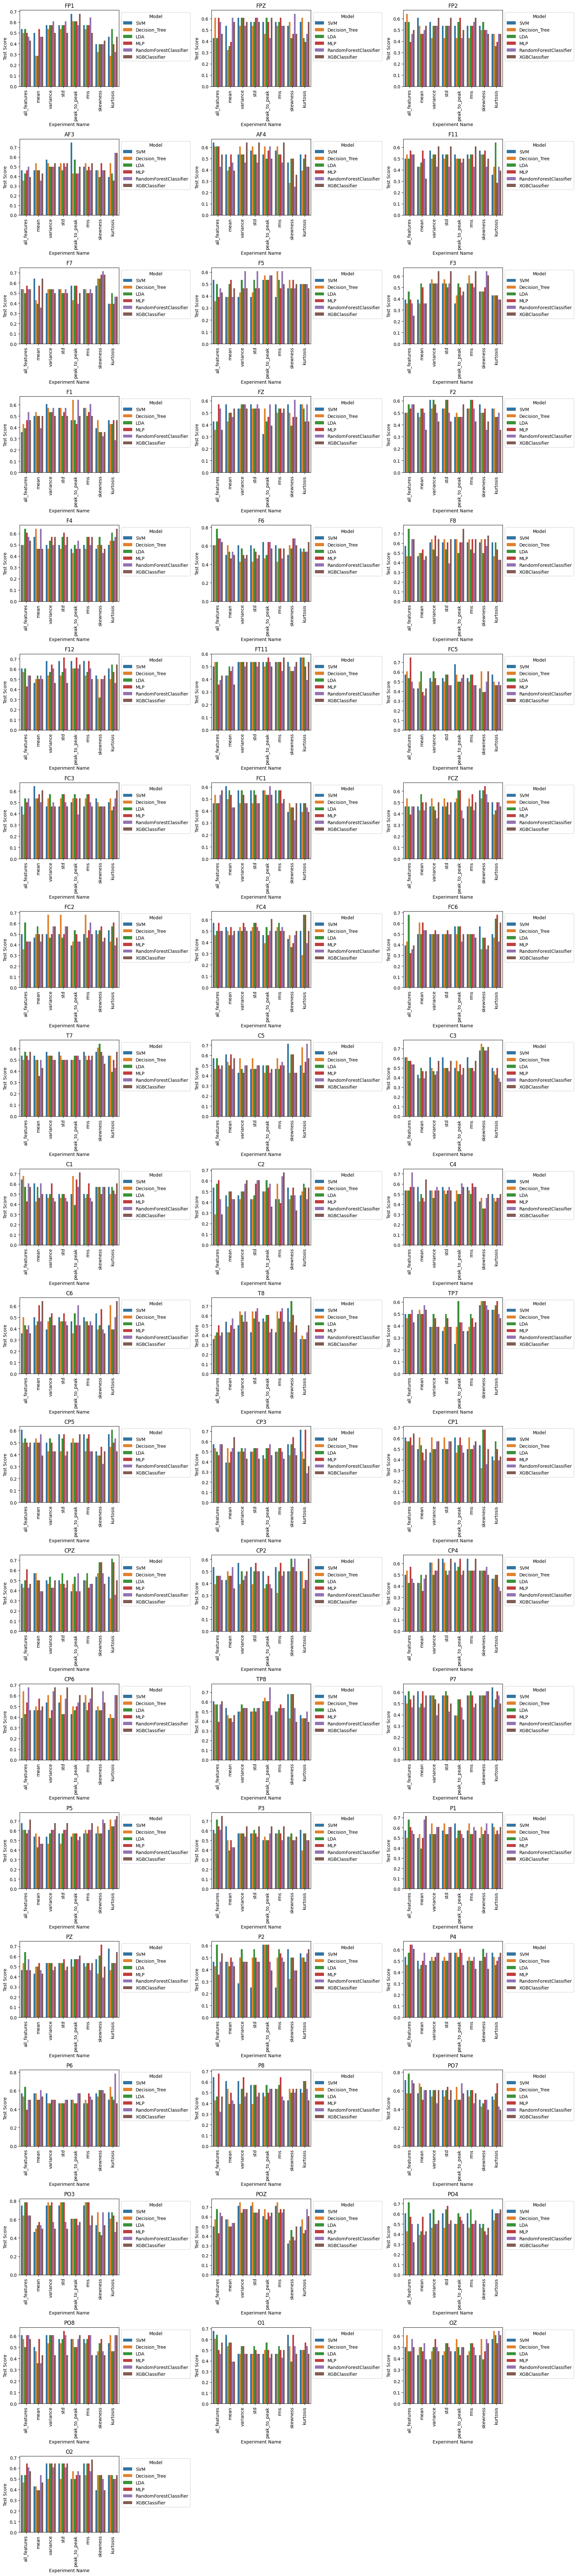

In [32]:
# Calculate the number of rows and columns for subplots
num_channels = 58
num_cols = 3  # or any number you prefer
num_rows = (num_channels // num_cols) + (num_channels % num_cols > 0)

# Create a figure and axis objects
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over channels and plot
for idx, (channel_name, results) in enumerate(channel_wise_results.items()):
    sns.barplot(
        data=results,
        x="experiment_name",
        y="test_score",
        hue="model_name",
        errorbar="sd",
        ax=axes[idx],
    )
    # Adding titles and labels to each subplot
    axes[idx].set_title(channel_name)
    axes[idx].set_xlabel("Experiment Name")
    axes[idx].set_ylabel("Test Score")
    axes[idx].tick_params(
        axis="x", rotation=90
    )  # Rotate the x-axis labels for better readability
    axes[idx].legend(title="Model", loc="best", bbox_to_anchor=(1, 1))

# Remove any empty subplots
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()